In [431]:
import urllib.request
import json
import time
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import numpy as np

In [432]:
import seaborn as sns

In [ ]:
offsets = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
token = 'c894cb434dc5920b4782189fccec07c1692baabd0707170c6b03e950daba133a59e30abb371c1dc862909'
version = '5.92'
domain = 'live_kras'

posts = []
# выкачиваем посты
for off in offsets:
    req = urllib.request.Request('https://api.vk.com/method/wall.get?domain=%s&count=100&access_token=%s&v=%s&offset=%s'  % (domain, token, version, off))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result) 
    posts.extend(data['response']['items'])
len(posts)

In [ ]:
owner_id = '-34183390'

# выкачиваем комментарии
comments = {}
for post in posts:
    post_id = post['id']
    comments[post_id] = []
    req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=%s&post_id=%s&count=100&access_token=%s&v=%s'  % (owner_id, post_id, token, version))
    time.sleep(0.3)
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result) 
    comments[post_id].extend(data['response']['items'])
    off = 0
    while data['response']['items'] != []:
        off += 100
        req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=%s&post_id=%s&count=100&access_token=%s&v=%s&offset=%s'  % (owner_id, post_id, token, version, off))
        time.sleep(0.3)
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result) 
        comments[post_id].extend(data['response']['items'])
print(len(comments))

In [ ]:
comments_list = []
for post,comments in comments.items():
    comments_list.append(comments)
len(comments_list)

In [ ]:
# находим информацию об авторе комментария - пол и возраст
users_info = {}
for post in comments_list:
    for comment in post:
        if 'from_id' not in comment:
            continue
        user_id = comment['from_id']
        if user_id in users_info.keys():
            continue
        req = urllib.request.Request('https://api.vk.com/method/users.get?user_ids=%s&fields=sex,bdate&access_token=%s&v=%s'  % (user_id, token, version))
        time.sleep(0.3)
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result) 
        if 'error' in data:
            continue
        param_dict = {}
        param_dict['sex'] = data['response'][0]['sex']
        if 'bdate' not in data['response'][0]:
            continue
        param_dict['bday'] = data['response'][0]['bdate']
        users_info[user_id] = param_dict

In [ ]:
relevant_data = []
for n, post in enumerate(posts):
    if 'text' not in post:
        continue
    d_for_post = {}
    d_for_post['post_id'] = post['id']
    d_for_post['text'] = post['text']
    d_for_post['date'] = time.ctime(int(post['date']))
    comments = []
    for comment in comments_list[n]:
        new_comment = {}
        if 'text' not in comment:
            continue
        new_comment['comment_text'] = comment['text']
        if comment['from_id'] not in users_info:
            continue
        new_comment['age_of_comment'] = users_info[comment['from_id']]['bday']
        new_comment['sex_of_comment'] = users_info[comment['from_id']]['sex']
        comments.append(new_comment)
    d_for_post['comments'] = comments
    relevant_data.append(d_for_post) 

In [ ]:
# сохраняем данные
with open('data.txt','w',encoding='utf-8') as f:
    json.dump(relevant_data, f)

In [ ]:
# вычисляем длину поста и среднюю длинну его комментариев
for post in relevant_data:
    post['text_len'] = len(post['text'].split())
    len_of_all_comments = 0
    number_of_comments = 0
    for comment in post['comments']:
        comment['comment_len'] = len(comment['comment_text'].split())
        len_of_all_comments += comment['comment_len']
        number_of_comments += 1
    if number_of_comments == 0:
        post['avrg_len_comment'] = 0
    else:
        post['avrg_len_comment'] = len_of_all_comments / number_of_comments

In [ ]:
# вычисляем среднюю длину поста к средней длине комментариев
len_post_to_len_comments = {}
for post in relevant_data:
    if post['text_len'] in len_post_to_len_comments:
        len_post_to_len_comments[post['text_len']].append(post['avrg_len_comment'])
    else:
        len_post_to_len_comments[post['text_len']] = [post['avrg_len_comment']]

In [ ]:
for text_len in len_post_to_len_comments:
    average = sum(len_post_to_len_comments[text_len]) / len(len_post_to_len_comments[text_len])
    len_post_to_len_comments[text_len] = average

In [ ]:
# данные для графика про отношение длины поста к длине комментария
X_text_len = []
Y_comment_len = []
for text_len, comment_len in len_post_to_len_comments.items():
    X_text_len.append(text_len)
    Y_comment_len.append(comment_len)

In [ ]:
# данные для регрессии
X_train = np.array(X_text_len).reshape(-1, 1)
Y_train = np.array(Y_comment_len).reshape(-1, 1)

In [ ]:
# регрессия
LR = lm.LinearRegression()
LR.fit(X_train, Y_train)
y_pred = LR.predict(X_train)

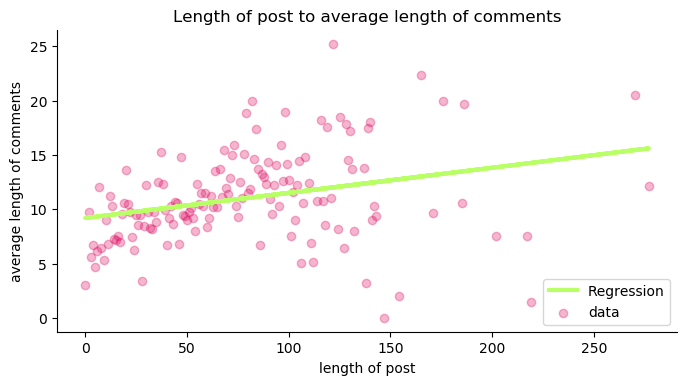

In [433]:
# строим график отношения длины поста к длине комментария
plt.figure(figsize=(8, 4), dpi=100)
plt.scatter(X_text_len, Y_comment_len, color="xkcd:cerise", alpha=0.3)
plt.plot(X_train, y_pred, linewidth=3, color="xkcd:light lime green")
plt.legend(["Regression","data"], loc=4)
sns.despine()
plt.xlabel("length of post")
plt.title("Length of post to average length of comments")
plt.ylabel("average length of comments")
plt.savefig('len_of_post_to_len_of_comment.png')
plt.show()

In [ ]:
# собираем информацию про день и час публикации
# так как в Красноярске другой часовой пояс (+4 к московкому времени), нужно перевести дату
next_day = {'Mon':'Tue', 'Tue':'Wed', 'Wed':'Thu', 'Thu':'Fri', 'Fri':'Sat', 'Sat':'Sun', 'Sun':'Mon'}
for post in relevant_data:
    post['day_of_week'] = post['date'].split()[0]
    post['hour'] = post['date'].split()[3].split(':')[0]
    if post['hour'] in ['20', '21', '22', '23']:
        post['day_of_week'] = next_day[post['day_of_week']]
        post['hour'] = int(post['hour']) - 20
    else:
        post['hour'] = int(post['hour']) + 4

In [ ]:
# вычисляем среднюю длину поста ко дню недели и часу
day_to_len_post = {}
hour_to_len_post = {}
for post in relevant_data:
    if post['day_of_week'] in day_to_len_post:
        day_to_len_post[post['day_of_week']].append(post['text_len'])
    else:
        day_to_len_post[post['day_of_week']] = [post['text_len']]
    if post['hour'] in hour_to_len_post:
        hour_to_len_post[post['hour']].append(post['text_len'])
    else:
        hour_to_len_post[post['hour']] = [post['text_len']]    

In [ ]:
for day in day_to_len_post:
    average = sum(day_to_len_post[day]) / len(day_to_len_post[day])
    day_to_len_post[day] = average

In [ ]:
for hour in hour_to_len_post:
    average = sum(hour_to_len_post[hour]) / len(hour_to_len_post[hour])
    hour_to_len_post[hour] = average

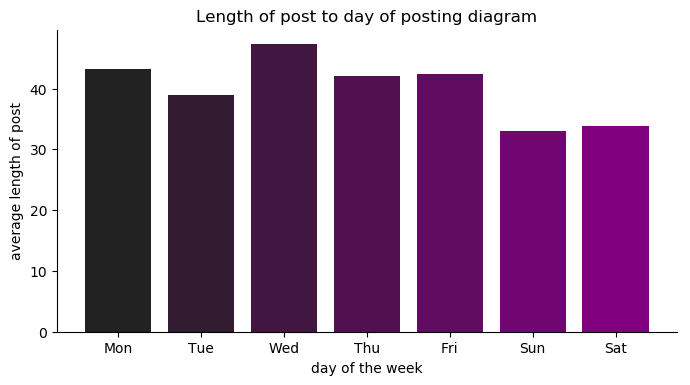

In [434]:
# данные для графиков отношения длины поста ко дню недели
X_day = []
Y_text = []
for day, text_len in day_to_len_post.items():
    X_day.append(day)
    Y_text.append(text_len)
# строим график отношения длины поста ко дню недели   
colors = sns.dark_palette("purple", n_colors=7)
plt.figure(figsize=(8, 4), dpi=100)
plt.bar(X_day[::-1], Y_text[::-1], color=colors)
sns.despine()
plt.title("Length of post to day of posting diagram")
plt.xlabel("day of the week")
plt.ylabel("average length of post")
plt.savefig('len_of_post_to_day.png')
plt.show()

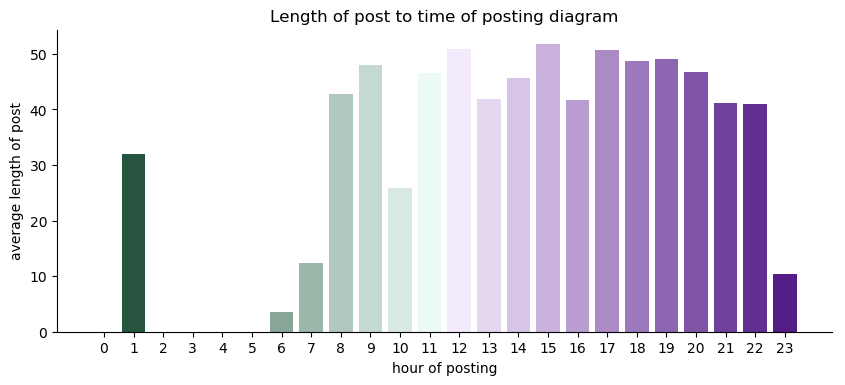

In [435]:
# данные для графиков отношения длины поста к часу
X_hour = []
Y_text = []
for i in range(0,24):
    X_hour.append(str(i))
    if i not in hour_to_len_post:
        Y_text.append(0)
    else:
        Y_text.append(hour_to_len_post[i])
# строим график отношения длины поста к часу
colors = sns.diverging_palette(145, 280, s=85, l=25, n=24)
plt.figure(figsize=(10, 4), dpi=100)
plt.bar(X_hour, Y_text, color=colors)
sns.despine()
plt.title("Length of post to time of posting diagram")
plt.xlabel("hour of posting")
plt.ylabel("average length of post")
plt.savefig('len_of_post_to_time.png')
plt.show()

In [ ]:
# вычисляем возраст комментатора
for post in relevant_data:
    for comment in post['comments']:
        comment['bday_of_comment'] = comment['age_of_comment']
        if len(comment['age_of_comment'].split('.')) == 3:
            comment['age_of_comment'] = 2019 - int(comment['age_of_comment'].split('.')[2])
        else:
            comment['age_of_comment'] = 'None'

In [ ]:
# вычисляем отношение возраста и пола к длине комментария
sex_to_len_comment = {}
age_to_len_comment = {}
for post in relevant_data:
    for comment in post['comments']:
        if comment['age_of_comment'] == 'None':
            continue
        if comment['age_of_comment'] in age_to_len_comment:
            age_to_len_comment[comment['age_of_comment']].append(comment['comment_len'])
        else:
            age_to_len_comment[comment['age_of_comment']] = [comment['comment_len']]
        if comment['sex_of_comment'] == 0:
            continue        
        if comment['sex_of_comment'] in sex_to_len_comment:
            sex_to_len_comment[comment['sex_of_comment']].append(comment['comment_len'])
        else:
            sex_to_len_comment[comment['sex_of_comment']] = [comment['comment_len']]

In [ ]:
for sex in sex_to_len_comment:
    average = sum(sex_to_len_comment[sex]) / len(sex_to_len_comment[sex])
    sex_to_len_comment[sex] = average

In [ ]:
for age in age_to_len_comment:
    average = sum(age_to_len_comment[age]) / len(age_to_len_comment[age])
    age_to_len_comment[age] = average

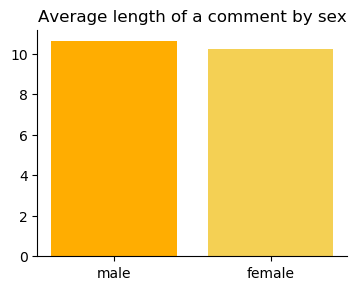

In [436]:
# строим график отношения длины комментария к полу
plt.figure(figsize=(4, 3), dpi=100)
plt.bar(['male','female'], sex_to_len_comment.values(), color=['xkcd:orange yellow','xkcd:maize'])
plt.title('Average length of a comment by sex')
sns.despine()
plt.savefig('len_of_comment_to_sex.png')
plt.show()

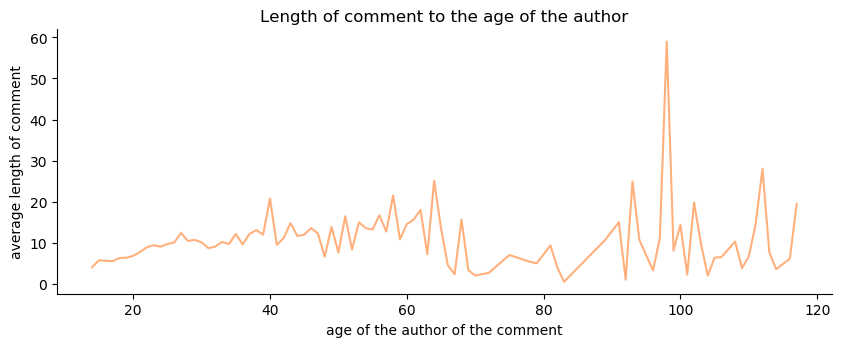

In [437]:
# строим график отношения длины комментария к возрасту
X_age = []
Y_text = []
for age, text_len in sorted(age_to_len_comment.items()):
    X_age.append(age)
    Y_text.append(text_len)

plt.figure(figsize=(10, 3.5), dpi=100)
plt.plot(X_age, Y_text, color='xkcd:peach')
plt.title("Length of comment to the age of the author")
plt.xlabel("age of the author of the comment")
plt.ylabel("average length of comment")
sns.despine()
plt.savefig('len_of_comment_to_age.png')
plt.show()

In [ ]:
import re

In [ ]:
# соединяем все тексты постов и комментариев, список слов
all_texts = ''
for post in relevant_data:
    all_texts += '\n' + post['text']
    for comment in post['comments']:
        all_texts += '\n' + comment['comment_text']
all_posts_no_punct = re.sub(r'[,.—–!?•:;"()]',r'', all_texts)
all_words_from_posts = all_posts_no_punct.lower().split()

In [ ]:
# сохраняем все тексты
with open('plain_text.txt','w', encoding='utf-8') as f:
    f.write(all_texts)

In [ ]:
# загружаем список стоп-слов - https://github.com/stopwords-iso/stopwords-ru
with open('stopwords-ru.json',encoding='utf-8') as f:
    stop_words = json.load(f)

In [ ]:
# добавляем стоп-слова, которые не попали в изначальный список
stop_words.extend(['-','в','на', 'не', 'что', 'и', 'с', 'это', 'этом', 'из-за', 'вы', 'возле', 'будет', 'не'])

In [ ]:
with open('new.txt', encoding='utf-8') as f:
    new = f.read()
new = new.splitlines()

In [ ]:
for word in new:
    if word not in stop_words:
        stop_words.append(word)

In [ ]:
# удаляем стоп-слова
all_words_no_stops = []
for word in all_words_from_posts:
    if word not in stop_words:
        all_words_no_stops.append(word)

In [ ]:
# сохраняем слова для лемматизации
with open('all_words.txt', 'w', encoding='utf-8') as f:
    for word in all_words_no_stops:
        f.write('%s\n' % word)

In [ ]:
from collections import Counter

In [ ]:
# считаем самые частотные слова по нелемматизированным текстам
freq_dict_posts = Counter(all_words_no_stops)

In [ ]:
most_common_30 = freq_dict_posts.most_common(30)

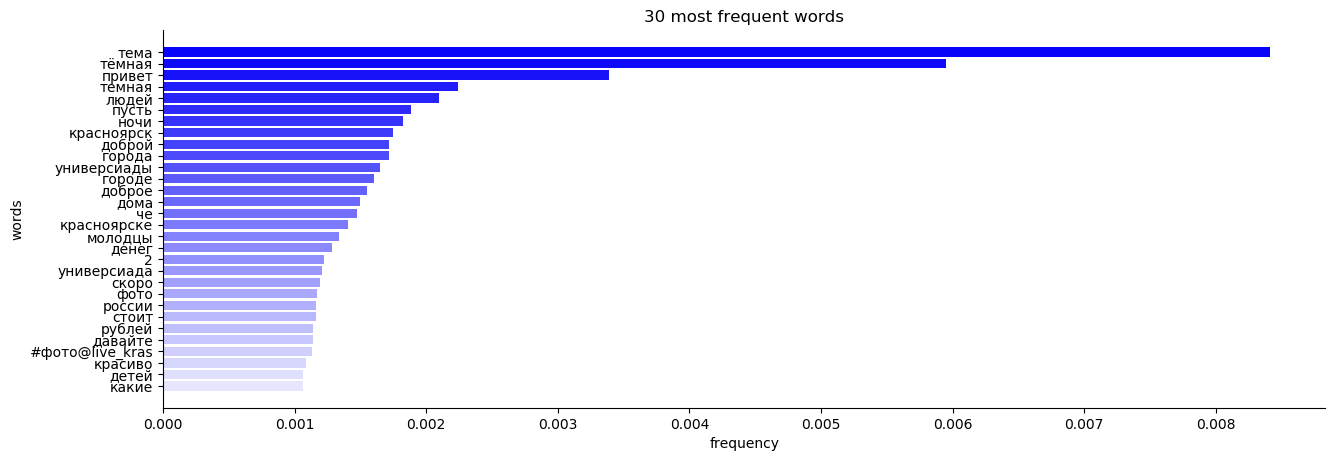

In [438]:
# строим график самых частотных слов по нелемматизированным текстам
X_word = []
Y_freq = []
for word in most_common_30:
    X_word.append(word[0])
    Y_freq.append(word[1] / len(all_words_no_stops))

plt.figure(figsize=(15, 5), dpi=100)
plt.barh(X_word[::-1], Y_freq[::-1], color=sns.light_palette("primary blue", input="xkcd", n_colors=30))
sns.despine()
plt.title('30 most frequent words')
plt.xlabel("frequency")
plt.ylabel("words")
plt.savefig('30_most_freq_no_lemm.png')
plt.show()

In [ ]:
# лемматизируем текст с помощью mystem
import os
os.system(r"C:\Users\Mi\Downloads\all_exes\mystem-3.1-win-64bit\mystem.exe C:\Users\Mi\Desktop\HSE\CODING\hw6\all_words.txt C:\Users\Mi\Desktop\HSE\CODING\hw6\plain_text_lemm.txt -ln")

In [ ]:
with open('plain_text_lemm.txt', encoding='utf-8') as f:
    all_words_lemm = f.read()

In [ ]:
# считаем самые частотные слова по лемматизированным текстам
freq_dict_posts_lemm = Counter(all_words_lemm.split())
most_common_30_lemm = freq_dict_posts_lemm.most_common(30)

In [ ]:
import unicodedata

In [ ]:
# в лемматизированном частотном словаре появились эмодзи - их сложно отобразить на графике
# меняем картинки на их названия
most_common_30_lemm_list = []
for pair in most_common_30_lemm:
    word = pair[0]
    if re.match(r'.\?\?', word) != None:
        word = unicodedata.name(word[0])
    most_common_30_lemm_list.append([word,pair[1]])

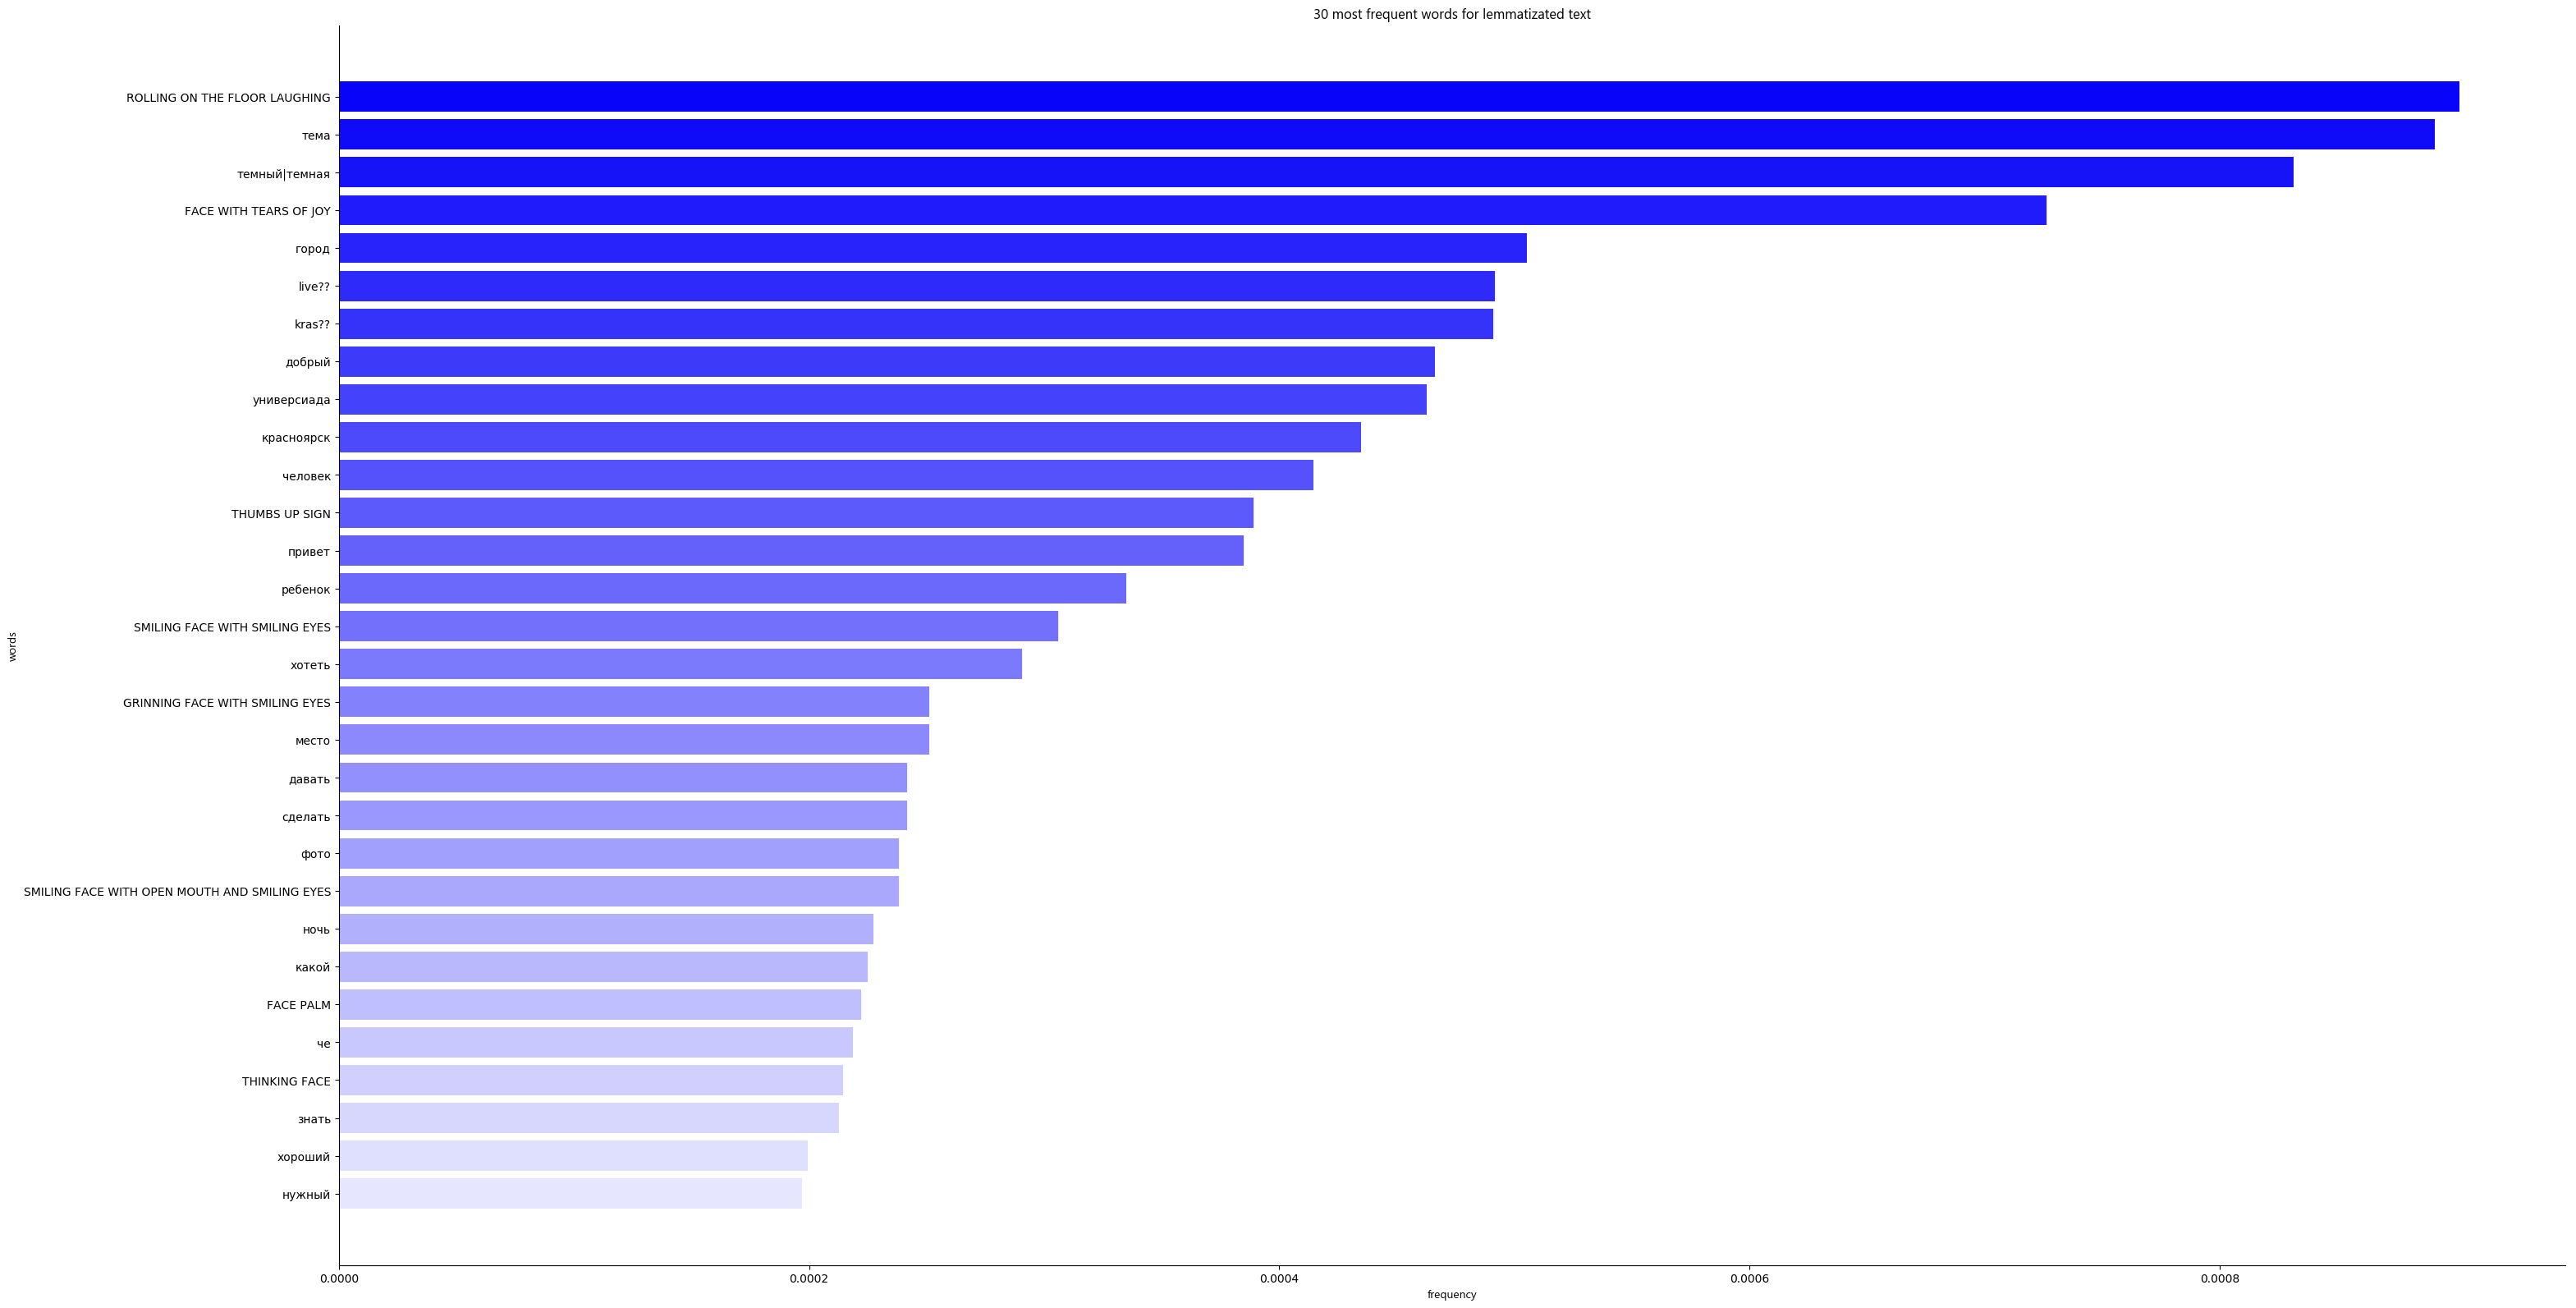

In [439]:
# строим график самых частотных слов по лемматизированным текстам
X_word_lemm = []
Y_freq_lemm = []
for word in most_common_30_lemm_list:
    X_word_lemm.append(word[0])
    Y_freq_lemm.append(word[1] / len(all_words_lemm))
plt.figure(figsize=(35, 20), dpi=100)
plt.barh(X_word_lemm[::-1], Y_freq_lemm[::-1], color=sns.light_palette("primary blue", input="xkcd", n_colors=30))
sns.despine()
plt.title('30 most frequent words for lemmatizated text', **hfont)
plt.xlabel("frequency", **hfont)
plt.ylabel("words", **hfont)
plt.savefig('30_most_freq_lemm.png')
plt.show()

In [ ]:
# создаем csv таблицу с данными
with open('data.csv', 'w', encoding='utf-8') as f:
    f.write('post or comment;id;text;date_of_post;sex_of_comment;age_of_comment\n')
    for post in relevant_data:
        text = re.sub(r'\n', r' ', post['text'])
        text = re.sub(r';', r',', text)
        post_id = post['post_id']
        post_date = post['date']
        f.write(f'post;{post_id};{text};{post_date};;\n')
        i = 1
        for comment in post['comments']:
                text_comment = re.sub(r'\n', r' ', comment['comment_text'])
                text_comment = re.sub(r';', r',', text_comment)
                comment_id = str(post['post_id']) + '.' + str(i)
                sex = comment['sex_of_comment']
                age = comment['age_of_comment']
                f.write(f'comment;{comment_id};{text_comment};;{sex};{age}\n')